In [1]:
from stanford_cs229.modeling.softmax import SoftmaxRegression
from stanford_cs229.modeling.k_means import KMeans
from stanford_cs229.modeling.perceptron import train_perceptron, predict_perceptron
from stanford_cs229.utils.util import load_our_data, plot, preprocess_rolling_avg, cmap
from stanford_cs229.utils.csv_plotter_classifier import format_data

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(plt)
%matplotlib notebook


# Number of class for learning
K = 5
plt_counter = 0

# Load data and preprocess for K-means
raw_data = load_our_data('stanford_cs229/data/ydeskx_overhand_weight_4-60Hz_extended2.csv')
raw_data = raw_data / raw_data.max()
X_tr = preprocess_rolling_avg(raw_data)
X_tr = X_tr / X_tr.max()


# Run K-means to get labels
print("** Running K-means to label raw data **")
k_means = KMeans(verbose=True)
Y_tr_k_means = k_means.assign(X_tr, K, random=True)

** Running K-means to label raw data **
Iteration: 1, Loss: 337.67501191422144
Iteration: 2, Loss: 257.1629268648116
Iteration: 3, Loss: 219.07184562861124
Iteration: 4, Loss: 193.34973874711736
Iteration: 5, Loss: 179.8045032718629
Iteration: 6, Loss: 175.17258784868102
Iteration: 7, Loss: 173.79345374442264
Iteration: 8, Loss: 173.5099278798964
Iteration: 9, Loss: 173.42061644502047
Iteration: 10, Loss: 173.37851392443832
Iteration: 11, Loss: 173.35735466648947
Iteration: 12, Loss: 173.344485560976
Iteration: 13, Loss: 173.3417901745885
Iteration: 14, Loss: 173.34075741420307
Iteration: 15, Loss: 173.33932509788266
Iteration: 16, Loss: 173.33855278222754
Iteration: 17, Loss: 173.33775581569603
Iteration: 18, Loss: 173.33721276381024
Iteration: 19, Loss: 173.33686934339136
Iteration: 20, Loss: 173.33682934809002
Iteration: 21, Loss: 173.33675023402589
Iteration: 22, Loss: 173.33675023402589
Time: 0:00:15.592409


In [26]:
class VanillaModel(tf.keras.Model):
  def __init__(self):
    super(VanillaModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(64, activation='relu')
    self.d2 = tf.keras.layers.Dense(128, activation='relu')
    self.d3 = tf.keras.layers.Dense(128, activation='relu')
    self.d4 = tf.keras.layers.Dense(5)
  
  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)
    return x
  
model = VanillaModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(x, labels):
  with tf.GradientTape() as tape:
    predictions = model(x)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(labels, predictions)
  
@tf.function
def test_step(x, labels):
  predictions = model(x)
  print(predictions.shape)
  test_loss = loss_object(labels, predictions)
  test_accuracy(labels, predictions)
  
EPOCHS = 1000

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  
  shuffler = np.random.permutation(raw_data.shape[0])
  X_tr = X_tr[shuffler]
  raw_data = raw_data[shuffler]
  Y_tr_k_means = Y_tr_k_means[shuffler]
  
  train_step(raw_data, Y_tr_k_means)
  test_step(raw_data, Y_tr_k_means)
  
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(12000, 5)
Epoch 1, Loss: 1.600642204284668, Accuracy: 13.074999809265137, Test Loss: 0.0, Test Accuracy: 13.675000190734863
Epoch 2, Loss: 1.5940417051315308, Accuracy: 13.675000190734863, Test Loss: 0.0, Test Accuracy: 14.533333778381348
Epoch 3, Loss: 1.5875868797302246, Accuracy: 14.533333778381348, Test Loss: 0.0, Test Accuracy: 39.266666412353516
Epoch 4, Loss: 1.581272006034851, Accuracy: 39.266666412353516, Test Loss: 0.0, Test Accuracy: 45.59166717529297
Epoch 5, Loss: 1.575097680091858, Accura

Epoch 81, Loss: 1.2400821447372437, Accuracy: 52.79999923706055, Test Loss: 0.0, Test Accuracy: 52.96666717529297
Epoch 82, Loss: 1.2360845804214478, Accuracy: 52.96666717529297, Test Loss: 0.0, Test Accuracy: 53.10000228881836
Epoch 83, Loss: 1.2321056127548218, Accuracy: 53.10000228881836, Test Loss: 0.0, Test Accuracy: 53.24166488647461
Epoch 84, Loss: 1.2281464338302612, Accuracy: 53.24166488647461, Test Loss: 0.0, Test Accuracy: 53.29999923706055
Epoch 85, Loss: 1.2242103815078735, Accuracy: 53.29999923706055, Test Loss: 0.0, Test Accuracy: 53.41666793823242
Epoch 86, Loss: 1.2202999591827393, Accuracy: 53.41666793823242, Test Loss: 0.0, Test Accuracy: 53.57499694824219
Epoch 87, Loss: 1.2164173126220703, Accuracy: 53.57499694824219, Test Loss: 0.0, Test Accuracy: 53.750003814697266
Epoch 88, Loss: 1.2125639915466309, Accuracy: 53.750003814697266, Test Loss: 0.0, Test Accuracy: 53.974998474121094
Epoch 89, Loss: 1.2087459564208984, Accuracy: 53.974998474121094, Test Loss: 0.0, Tes

Epoch 153, Loss: 1.0389471054077148, Accuracy: 57.90833282470703, Test Loss: 0.0, Test Accuracy: 57.92499923706055
Epoch 154, Loss: 1.0372968912124634, Accuracy: 57.92499923706055, Test Loss: 0.0, Test Accuracy: 57.93333053588867
Epoch 155, Loss: 1.0356636047363281, Accuracy: 57.93333053588867, Test Loss: 0.0, Test Accuracy: 57.93333053588867
Epoch 156, Loss: 1.03404700756073, Accuracy: 57.93333053588867, Test Loss: 0.0, Test Accuracy: 57.99166488647461
Epoch 157, Loss: 1.0324450731277466, Accuracy: 57.99166488647461, Test Loss: 0.0, Test Accuracy: 58.008331298828125
Epoch 158, Loss: 1.0308369398117065, Accuracy: 58.008331298828125, Test Loss: 0.0, Test Accuracy: 58.01666259765625
Epoch 159, Loss: 1.0292304754257202, Accuracy: 58.01666259765625, Test Loss: 0.0, Test Accuracy: 58.008331298828125
Epoch 160, Loss: 1.0276339054107666, Accuracy: 58.008331298828125, Test Loss: 0.0, Test Accuracy: 58.04166793823242
Epoch 161, Loss: 1.0260545015335083, Accuracy: 58.04166793823242, Test Loss: 0

Epoch 238, Loss: 0.9392041563987732, Accuracy: 60.20000076293945, Test Loss: 0.0, Test Accuracy: 60.21666717529297
Epoch 239, Loss: 0.9383528828620911, Accuracy: 60.21666717529297, Test Loss: 0.0, Test Accuracy: 60.30833053588867
Epoch 240, Loss: 0.9375051259994507, Accuracy: 60.30833053588867, Test Loss: 0.0, Test Accuracy: 60.36666488647461
Epoch 241, Loss: 0.9366609454154968, Accuracy: 60.36666488647461, Test Loss: 0.0, Test Accuracy: 60.4083366394043
Epoch 242, Loss: 0.935820460319519, Accuracy: 60.4083366394043, Test Loss: 0.0, Test Accuracy: 60.4666633605957
Epoch 243, Loss: 0.9349833726882935, Accuracy: 60.4666633605957, Test Loss: 0.0, Test Accuracy: 60.50833511352539
Epoch 244, Loss: 0.9341500401496887, Accuracy: 60.50833511352539, Test Loss: 0.0, Test Accuracy: 60.608333587646484
Epoch 245, Loss: 0.9333204627037048, Accuracy: 60.608333587646484, Test Loss: 0.0, Test Accuracy: 60.67500305175781
Epoch 246, Loss: 0.9324944615364075, Accuracy: 60.67500305175781, Test Loss: 0.0, T

Epoch 322, Loss: 0.8767905235290527, Accuracy: 64.55833435058594, Test Loss: 0.0, Test Accuracy: 64.61666870117188
Epoch 323, Loss: 0.8761322498321533, Accuracy: 64.61666870117188, Test Loss: 0.0, Test Accuracy: 64.69166564941406
Epoch 324, Loss: 0.8754766583442688, Accuracy: 64.69166564941406, Test Loss: 0.0, Test Accuracy: 64.7249984741211
Epoch 325, Loss: 0.8748233914375305, Accuracy: 64.7249984741211, Test Loss: 0.0, Test Accuracy: 64.80000305175781
Epoch 326, Loss: 0.87417072057724, Accuracy: 64.80000305175781, Test Loss: 0.0, Test Accuracy: 64.9000015258789
Epoch 327, Loss: 0.8735188841819763, Accuracy: 64.9000015258789, Test Loss: 0.0, Test Accuracy: 64.96666717529297
Epoch 328, Loss: 0.8728675246238708, Accuracy: 64.96666717529297, Test Loss: 0.0, Test Accuracy: 65.01667022705078
Epoch 329, Loss: 0.8722162842750549, Accuracy: 65.01667022705078, Test Loss: 0.0, Test Accuracy: 65.08332824707031
Epoch 330, Loss: 0.8715651631355286, Accuracy: 65.08332824707031, Test Loss: 0.0, Test

Epoch 412, Loss: 0.8243876695632935, Accuracy: 68.19166564941406, Test Loss: 0.0, Test Accuracy: 68.19999694824219
Epoch 413, Loss: 0.8238958120346069, Accuracy: 68.19999694824219, Test Loss: 0.0, Test Accuracy: 68.26666259765625
Epoch 414, Loss: 0.8234056234359741, Accuracy: 68.26666259765625, Test Loss: 0.0, Test Accuracy: 68.30833435058594
Epoch 415, Loss: 0.8229165077209473, Accuracy: 68.30833435058594, Test Loss: 0.0, Test Accuracy: 68.34166717529297
Epoch 416, Loss: 0.8224295377731323, Accuracy: 68.34166717529297, Test Loss: 0.0, Test Accuracy: 68.35832977294922
Epoch 417, Loss: 0.821943998336792, Accuracy: 68.35832977294922, Test Loss: 0.0, Test Accuracy: 68.375
Epoch 418, Loss: 0.821459949016571, Accuracy: 68.375, Test Loss: 0.0, Test Accuracy: 68.39167022705078
Epoch 419, Loss: 0.8209772109985352, Accuracy: 68.39167022705078, Test Loss: 0.0, Test Accuracy: 68.4000015258789
Epoch 420, Loss: 0.8204967379570007, Accuracy: 68.4000015258789, Test Loss: 0.0, Test Accuracy: 68.416664

Epoch 500, Loss: 0.7850956320762634, Accuracy: 70.26666259765625, Test Loss: 0.0, Test Accuracy: 70.25833129882812
Epoch 501, Loss: 0.7846964597702026, Accuracy: 70.25833129882812, Test Loss: 0.0, Test Accuracy: 70.26666259765625
Epoch 502, Loss: 0.7842978239059448, Accuracy: 70.26666259765625, Test Loss: 0.0, Test Accuracy: 70.28333282470703
Epoch 503, Loss: 0.7838998436927795, Accuracy: 70.28333282470703, Test Loss: 0.0, Test Accuracy: 70.2750015258789
Epoch 504, Loss: 0.783502459526062, Accuracy: 70.2750015258789, Test Loss: 0.0, Test Accuracy: 70.31666564941406
Epoch 505, Loss: 0.7831058502197266, Accuracy: 70.31666564941406, Test Loss: 0.0, Test Accuracy: 70.31666564941406
Epoch 506, Loss: 0.7827106714248657, Accuracy: 70.31666564941406, Test Loss: 0.0, Test Accuracy: 70.31666564941406
Epoch 507, Loss: 0.7823160886764526, Accuracy: 70.31666564941406, Test Loss: 0.0, Test Accuracy: 70.34166717529297
Epoch 508, Loss: 0.781922459602356, Accuracy: 70.34166717529297, Test Loss: 0.0, Te

Epoch 582, Loss: 0.7540151476860046, Accuracy: 71.85833740234375, Test Loss: 0.0, Test Accuracy: 71.88333129882812
Epoch 583, Loss: 0.753649890422821, Accuracy: 71.88333129882812, Test Loss: 0.0, Test Accuracy: 71.90833282470703
Epoch 584, Loss: 0.7532848119735718, Accuracy: 71.90833282470703, Test Loss: 0.0, Test Accuracy: 71.93333435058594
Epoch 585, Loss: 0.7529200911521912, Accuracy: 71.93333435058594, Test Loss: 0.0, Test Accuracy: 71.96666717529297
Epoch 586, Loss: 0.7525554895401001, Accuracy: 71.96666717529297, Test Loss: 0.0, Test Accuracy: 71.98332977294922
Epoch 587, Loss: 0.7521911859512329, Accuracy: 71.98332977294922, Test Loss: 0.0, Test Accuracy: 72.0
Epoch 588, Loss: 0.7518270015716553, Accuracy: 72.0, Test Loss: 0.0, Test Accuracy: 72.03333282470703
Epoch 589, Loss: 0.7514630556106567, Accuracy: 72.03333282470703, Test Loss: 0.0, Test Accuracy: 72.04166412353516
Epoch 590, Loss: 0.7510994672775269, Accuracy: 72.04166412353516, Test Loss: 0.0, Test Accuracy: 72.0583343

Epoch 661, Loss: 0.7255932688713074, Accuracy: 73.4000015258789, Test Loss: 0.0, Test Accuracy: 73.42500305175781
Epoch 662, Loss: 0.7252395749092102, Accuracy: 73.42500305175781, Test Loss: 0.0, Test Accuracy: 73.43333435058594
Epoch 663, Loss: 0.7248862385749817, Accuracy: 73.43333435058594, Test Loss: 0.0, Test Accuracy: 73.44166564941406
Epoch 664, Loss: 0.7245333790779114, Accuracy: 73.44166564941406, Test Loss: 0.0, Test Accuracy: 73.44999694824219
Epoch 665, Loss: 0.7241808176040649, Accuracy: 73.44999694824219, Test Loss: 0.0, Test Accuracy: 73.46666717529297
Epoch 666, Loss: 0.7238285541534424, Accuracy: 73.46666717529297, Test Loss: 0.0, Test Accuracy: 73.48333740234375
Epoch 667, Loss: 0.7234769463539124, Accuracy: 73.48333740234375, Test Loss: 0.0, Test Accuracy: 73.49166870117188
Epoch 668, Loss: 0.7231255173683167, Accuracy: 73.49166870117188, Test Loss: 0.0, Test Accuracy: 73.5250015258789
Epoch 669, Loss: 0.7227743268013, Accuracy: 73.5250015258789, Test Loss: 0.0, Test

Epoch 741, Loss: 0.6983906030654907, Accuracy: 74.65833282470703, Test Loss: 0.0, Test Accuracy: 74.68333435058594
Epoch 742, Loss: 0.6980648636817932, Accuracy: 74.68333435058594, Test Loss: 0.0, Test Accuracy: 74.69999694824219
Epoch 743, Loss: 0.6977391839027405, Accuracy: 74.69999694824219, Test Loss: 0.0, Test Accuracy: 74.7249984741211
Epoch 744, Loss: 0.6974140405654907, Accuracy: 74.7249984741211, Test Loss: 0.0, Test Accuracy: 74.7249984741211
Epoch 745, Loss: 0.6970892548561096, Accuracy: 74.7249984741211, Test Loss: 0.0, Test Accuracy: 74.75833129882812
Epoch 746, Loss: 0.6967645883560181, Accuracy: 74.75833129882812, Test Loss: 0.0, Test Accuracy: 74.76666259765625
Epoch 747, Loss: 0.6964404582977295, Accuracy: 74.76666259765625, Test Loss: 0.0, Test Accuracy: 74.7750015258789
Epoch 748, Loss: 0.6961168050765991, Accuracy: 74.7750015258789, Test Loss: 0.0, Test Accuracy: 74.78333282470703
Epoch 749, Loss: 0.6957934498786926, Accuracy: 74.78333282470703, Test Loss: 0.0, Test

Epoch 823, Loss: 0.6727667450904846, Accuracy: 75.74166870117188, Test Loss: 0.0, Test Accuracy: 75.74166870117188
Epoch 824, Loss: 0.6724675893783569, Accuracy: 75.74166870117188, Test Loss: 0.0, Test Accuracy: 75.73333740234375
Epoch 825, Loss: 0.6721686720848083, Accuracy: 75.73333740234375, Test Loss: 0.0, Test Accuracy: 75.74166870117188
Epoch 826, Loss: 0.671870231628418, Accuracy: 75.74166870117188, Test Loss: 0.0, Test Accuracy: 75.76666259765625
Epoch 827, Loss: 0.6715718507766724, Accuracy: 75.76666259765625, Test Loss: 0.0, Test Accuracy: 75.80000305175781
Epoch 828, Loss: 0.6712737679481506, Accuracy: 75.80000305175781, Test Loss: 0.0, Test Accuracy: 75.8499984741211
Epoch 829, Loss: 0.6709761023521423, Accuracy: 75.8499984741211, Test Loss: 0.0, Test Accuracy: 75.84166717529297
Epoch 830, Loss: 0.6706786155700684, Accuracy: 75.84166717529297, Test Loss: 0.0, Test Accuracy: 75.82499694824219
Epoch 831, Loss: 0.6703809499740601, Accuracy: 75.82499694824219, Test Loss: 0.0, T

Epoch 907, Loss: 0.6486568450927734, Accuracy: 76.6500015258789, Test Loss: 0.0, Test Accuracy: 76.66666412353516
Epoch 908, Loss: 0.6483821868896484, Accuracy: 76.66666412353516, Test Loss: 0.0, Test Accuracy: 76.66666412353516
Epoch 909, Loss: 0.6481077671051025, Accuracy: 76.66666412353516, Test Loss: 0.0, Test Accuracy: 76.67499542236328
Epoch 910, Loss: 0.6478333473205566, Accuracy: 76.67499542236328, Test Loss: 0.0, Test Accuracy: 76.65833282470703
Epoch 911, Loss: 0.6475591659545898, Accuracy: 76.65833282470703, Test Loss: 0.0, Test Accuracy: 76.67499542236328
Epoch 912, Loss: 0.6472852230072021, Accuracy: 76.67499542236328, Test Loss: 0.0, Test Accuracy: 76.68333435058594
Epoch 913, Loss: 0.6470115780830383, Accuracy: 76.68333435058594, Test Loss: 0.0, Test Accuracy: 76.67499542236328
Epoch 914, Loss: 0.6467380523681641, Accuracy: 76.67499542236328, Test Loss: 0.0, Test Accuracy: 76.69166564941406
Epoch 915, Loss: 0.6464647054672241, Accuracy: 76.69166564941406, Test Loss: 0.0,

Epoch 994, Loss: 0.6256256699562073, Accuracy: 77.75, Test Loss: 0.0, Test Accuracy: 77.74166107177734
Epoch 995, Loss: 0.6253730654716492, Accuracy: 77.74166107177734, Test Loss: 0.0, Test Accuracy: 77.78333282470703
Epoch 996, Loss: 0.6251208186149597, Accuracy: 77.78333282470703, Test Loss: 0.0, Test Accuracy: 77.78333282470703
Epoch 997, Loss: 0.6248687505722046, Accuracy: 77.78333282470703, Test Loss: 0.0, Test Accuracy: 77.79166412353516
Epoch 998, Loss: 0.6246169209480286, Accuracy: 77.79166412353516, Test Loss: 0.0, Test Accuracy: 77.80000305175781
Epoch 999, Loss: 0.6243652105331421, Accuracy: 77.80000305175781, Test Loss: 0.0, Test Accuracy: 77.82499694824219
Epoch 1000, Loss: 0.624113917350769, Accuracy: 77.82499694824219, Test Loss: 0.0, Test Accuracy: 77.82499694824219


<IPython.core.display.Javascript object>


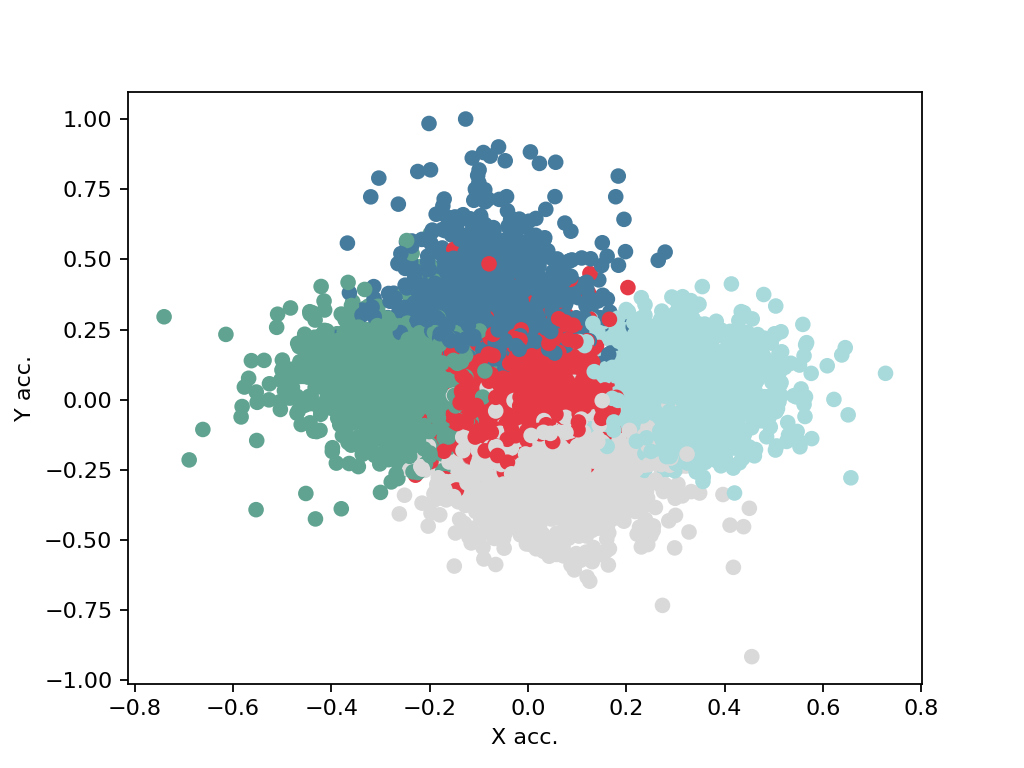

<IPython.core.display.Javascript object>


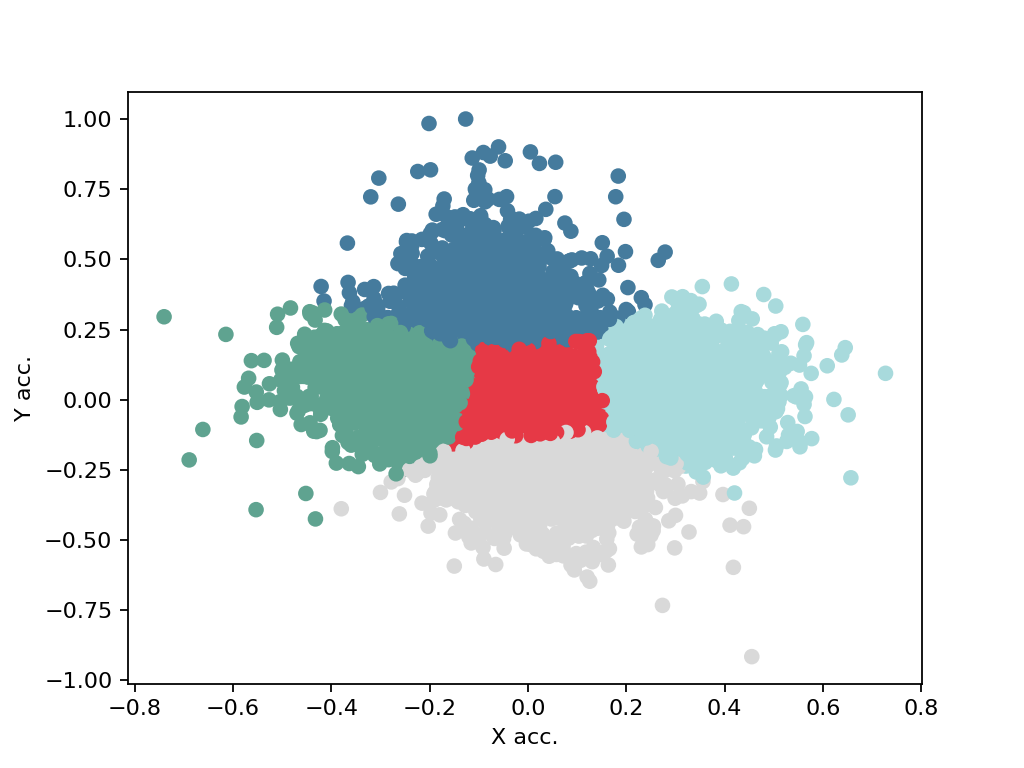

Text(0, 0.5, 'Y acc.')

In [24]:
# Plot data with predicted labels
fig1 = plt.figure(plt_counter)
plt_counter += 1
ax1 = plt.axes()
ax1.scatter(X_tr[:, 0], X_tr[:, 1], c=cmap(np.argmax(model(raw_data), axis=1)))
ax1.set_xlabel('X acc.')
ax1.set_ylabel('Y acc.')

# Plot data with predicted labels
fig2 = plt.figure(plt_counter)
plt_counter += 1
ax2 = plt.axes()
ax2.scatter(X_tr[:, 0], X_tr[:, 1], c=cmap(Y_tr_k_means))
ax2.set_xlabel('X acc.')
ax2.set_ylabel('Y acc.')